In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. 'monthly-us-auto-registration-tho.csv' 

In [2]:
df_auto_reg = pd.read_csv('monthly-us-auto-registration-tho.csv', delimiter=';')

In [3]:
df_auto_reg.head(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214


In [4]:
df_auto_reg.tail(2)

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
262,1968-11,757
263,1968-12,977


In [5]:
df_auto_reg.columns = ['Month', 'Registrations']

In [6]:
df_auto_reg.head()

,Month,Registrations
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


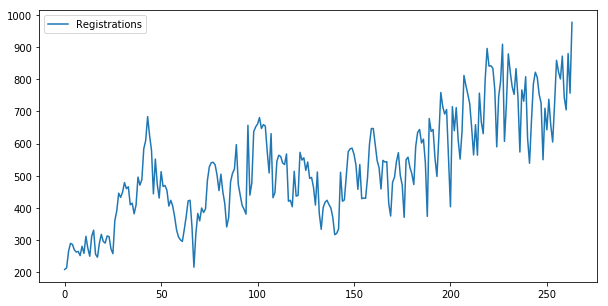

In [7]:
fig = df_auto_reg.plot(figsize=(10,5))

In [8]:
from statsmodels.tsa.stattools import adfuller

In [71]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [72]:
test_stationarity(df_auto_reg['Registrations'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


Ряд нестационарен, требуются преобразования.

Для начала нормализуем дисперсию.

In [73]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [74]:
df_auto_reg['Registrations_box'], lambd = boxcox(df_auto_reg['Registrations'])

In [75]:
lambd

0.49846845102590315

Возьмем сезонную разницу

In [76]:
df_auto_reg['Registrations_box_season'] = df_auto_reg['Registrations_box'].diff(12)

In [77]:
df_auto_reg['Registrations_box_season_diff_1'] = df_auto_reg['Registrations_box_season'].diff()

In [78]:
test_stationarity(df_auto_reg['Registrations_box_season_diff_1'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -6.604213e+00
p-value                        6.618944e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


In [79]:
def inverse_transform(series, df):
    """
    Функция для обратного преобразования стационарного ряда к исходному.
    """
    series = np.where(series.notna(), series, df_auto_reg['Registrations_box_season_diff_1'].dropna().reset_index(drop=True))
    series = pd.Series([None]*13).append(pd.Series(series)).reset_index(drop=True)
    box_season = series + df['Registrations_box_season'].shift(1)
    box_season[12] = df['Registrations_box_season'][12]
    season = box_season + df['Registrations_box'].shift(12)
    season[:12] = df['Registrations_box'][:12]
    box = inv_boxcox(season.astype(float), lambd)   
    return box

In [80]:
# нестационарный ряд
series_nst = df_auto_reg['Registrations']
# стационарный ряд
series_st = df_auto_reg['Registrations_box_season_diff_1'].dropna()

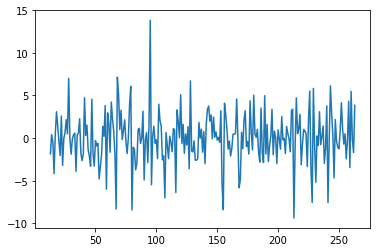

In [81]:
fig = plt.plot(series_st)

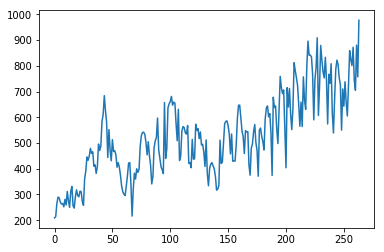

In [82]:
fig = plt.plot(series_nst)

In [83]:
series_st.reset_index(drop=True, inplace=True)

In [84]:
len(series_nst), len(series_st)

(264, 251)

In [85]:
# возьмем в качестве тестового и валидационного ряда период в 6 месяцев
train_st, test_st, val_st = series_st[:-12], series_st[-12:-6], series_st[-6:]
train_nst, test_nst, val_nst = series_nst[:-12], series_nst[-12:-6], series_nst[-6:]

In [86]:
from sklearn.metrics import mean_squared_error

# I. Стационарный ряд

#### 1.1 Скользящая средняя

In [87]:
def predict_ma(series, N, n_pred):
    new_series = series.copy()
    result = series.rolling(N).mean()
    for _ in range(n_pred):
        res = pd.Series([new_series[-N:].mean()])
        new_series = new_series.append(res, ignore_index=True)
        result = result.append(res, ignore_index=True)
    return result

In [88]:
def mse_ma(N, train, test):
    result = predict_ma(train, N, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [89]:
# выберем оптимальное значение окна
errors = []
for N in range(1, 24):
    errors.append(mse_ma(N, train_st, test_st))

In [90]:
N_opt = np.array(errors).argmin() + 1
N_opt

10

In [91]:
predictions_ma = predict_ma(series_st[:-6], N_opt, len(val_st))
ma_errors = mse_ma(N_opt, series_st[:-6], val_st)

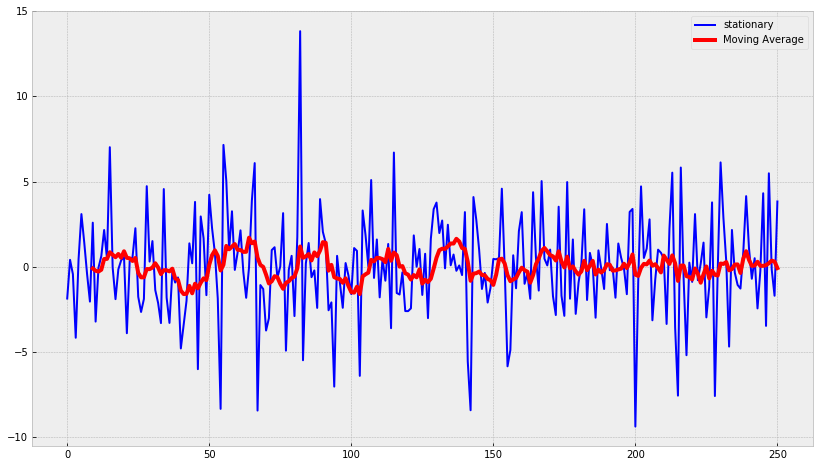

In [92]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='stationary')
    plt.plot(predictions_ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

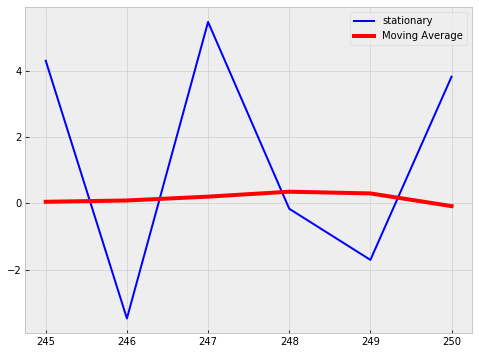

In [93]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(8, 6))
    plt.plot(series_st[-6:], color='blue',label='stationary')
    plt.plot(predictions_ma[-6:], color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [94]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_ma = inverse_transform(predictions_ma, df_auto_reg)

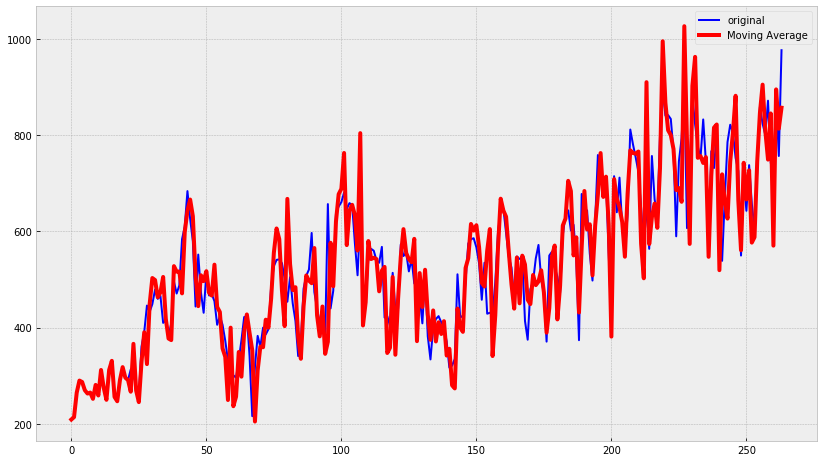

In [95]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

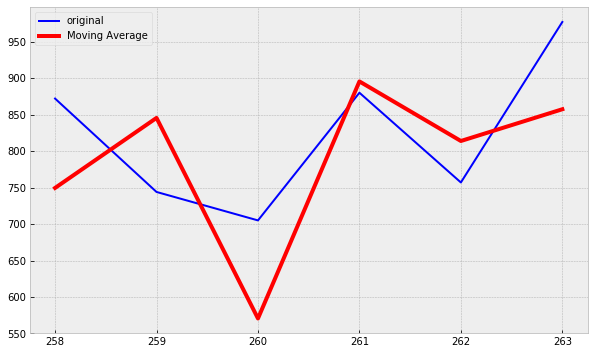

In [96]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(res_ma[-6:], color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [97]:
print(f'MSE на валидационном ряде для модели MA и стационарного ряда: {ma_errors:.2f}')

MSE на валидационном ряде для модели MA и стационарного ряда: 13.05


In [98]:
ma_nst_errors = mean_squared_error(val_nst, res_ma[-6:])
print(f'MSE на валидационном ряде для модели MA и нестационарного ряда: {ma_nst_errors:.2f}')

MSE на валидационном ряде для модели MA и нестационарного ряда: 10193.09


Предсказания скользящей средней на валидационном ряду - практически горизонтальная линия с небольшими отклонениями от нуля.

#### 1.2.  Взвешенная скользящая средняя (последовательные числа)

In [99]:
def predict_wma(series, N, n_pred):
    weights = np.arange(1, N+1)
    new_series = series.copy()
    result = series.rolling(N).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    for _ in range(n_pred):
        res = pd.Series([(np.array(new_series[-N:])*weights/weights.sum()).sum()])
        new_series = new_series.append(res, ignore_index=True)
        result = result.append(res, ignore_index=True)
    return result

In [100]:
def mse_wma(N, train, test):
    result = predict_wma(train, N, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [101]:
errors = []
# Найдем оптимальную ширину окна
for N in range(1, 12):
    errors.append(mse_wma(N, train_st, test_st))

In [102]:
N_opt = np.array(errors).argmin() + 1
N_opt

10

In [103]:
predictions_wma = predict_wma(series_st[:-6], N_opt, len(val_st))
wma_errors = mse_wma(N_opt, series_st[:-6], val_st)

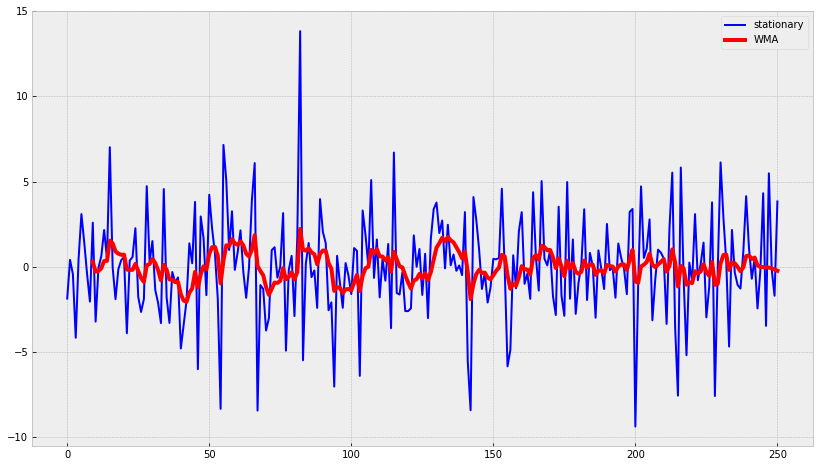

In [104]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='stationary')
    plt.plot(predictions_wma, color='red', linewidth='4', label='WMA')
    plt.legend()

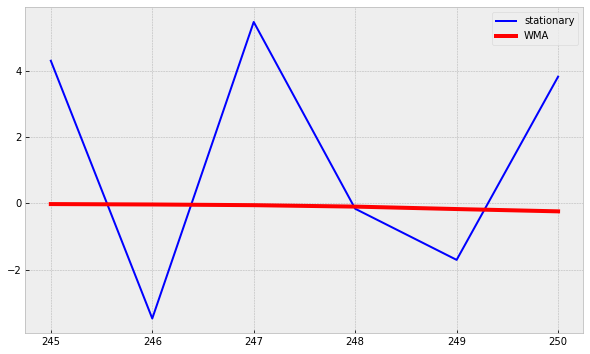

In [105]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_st[-6:], color='blue',label='stationary')
    plt.plot(predictions_wma[-6:], color='red', linewidth='4', label='WMA')
    plt.legend()

In [107]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_wma = inverse_transform(predictions_wma, df_auto_reg)

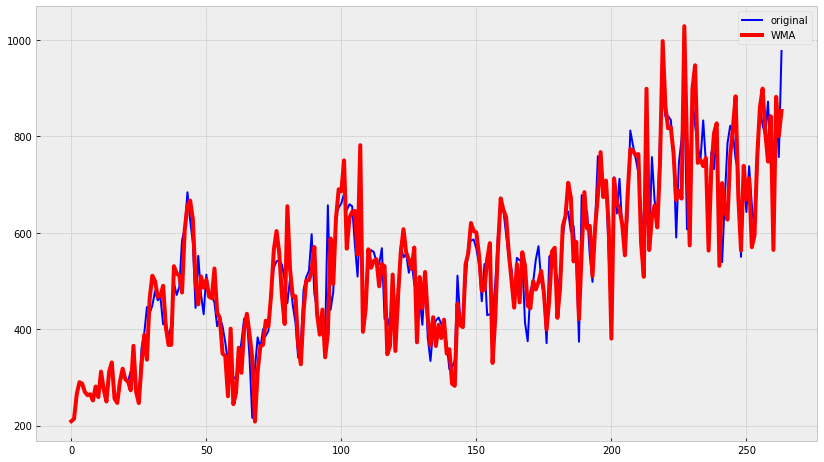

In [108]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_wma, color='red', linewidth='4', label='WMA')
    plt.legend()

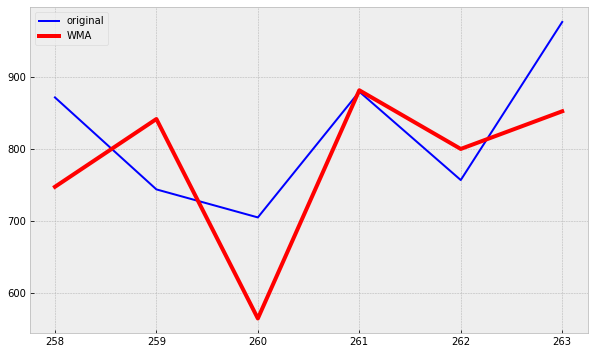

In [109]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(res_wma[-6:], color='red', linewidth='4', label='WMA')
    plt.legend()

In [110]:
print(f'MSE на валидационном ряде для модели WMA и стационарного ряда: {wma_errors:.2f}')

MSE на валидационном ряде для модели WMA и стационарного ряда: 13.36


In [111]:
wma_nst_errors = mean_squared_error(val_nst, res_wma[-6:])
print(f'MSE на валидационном ряде для модели WMA и нестационарного ряда: {wma_nst_errors:.2f}')

MSE на валидационном ряде для модели WMA и нестационарного ряда: 10362.26


Аналогичная скользящей средней картина.

#### 1.3. Экспоненциальное сглаживание

In [112]:
def predict_ema(series, alpha, n_pred):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return pd.Series(result)

In [113]:
def mse_ema(X, train, test):
    alpha = X
    result = predict_ema(train, alpha, len(test))
    predictions = result[-len(test_st):]
    error = mean_squared_error(predictions, test)
    return error

In [114]:
from scipy.optimize import minimize

In [115]:
opt = minimize(mse_ema, x0=[0.1], method="L-BFGS-B", 
               bounds = ((0.1, 0.9),), args= (train_st, test_st))

In [116]:
alpha_opt = opt.x[0]
print(opt)

      fun: 4.414491275251733
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.2332789])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
   status: 0
  success: True
        x: array([0.1])


In [117]:
alpha_opt

0.1

In [134]:
predictions_ema = predict_ema(series_st[:-6], alpha_opt, len(val_st))
ema_errors = mse_ema(alpha_opt, series_st[:-6], val_st)

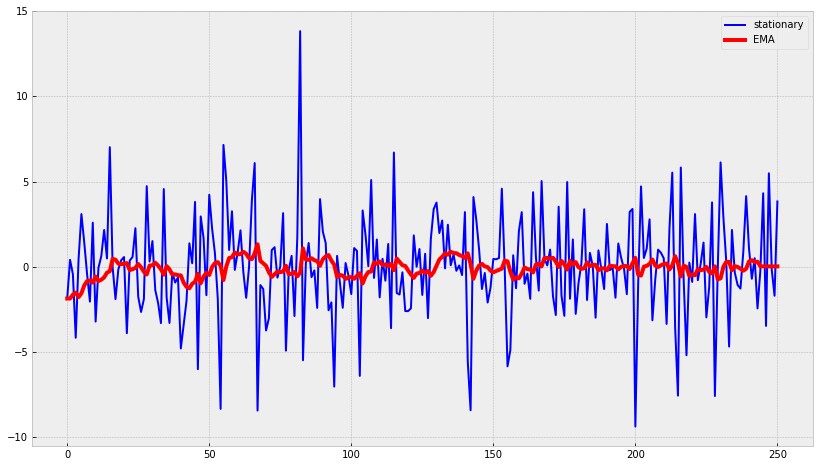

In [135]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='stationary')
    plt.plot(predictions_ema, color='red', linewidth='4', label='EMA')
    plt.legend()

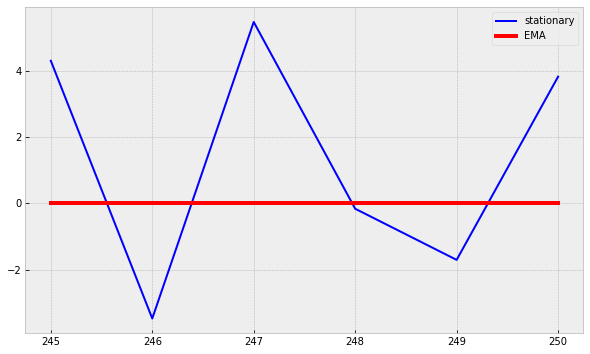

In [136]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_st[-6:], color='blue',label='stationary')
    plt.plot(predictions_ema[-6:], color='red', linewidth='4', label='EMA')
    plt.legend()

In [137]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_ema = inverse_transform(predictions_ema, df_auto_reg)

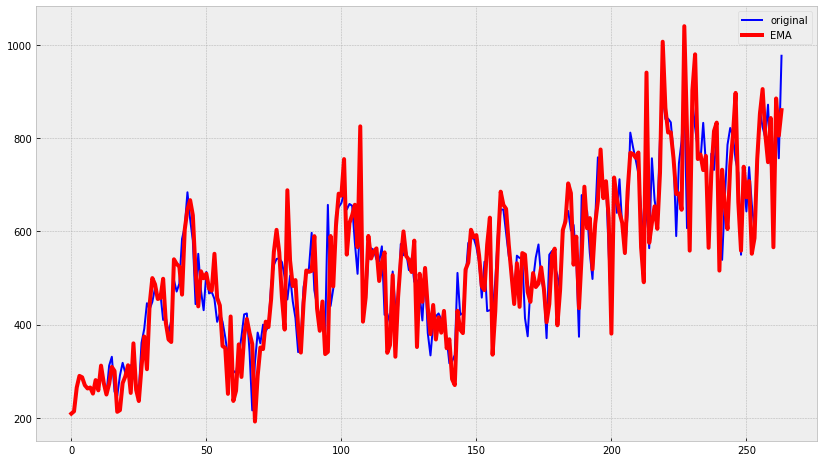

In [138]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_ema, color='red', linewidth='4', label='EMA')
    plt.legend()

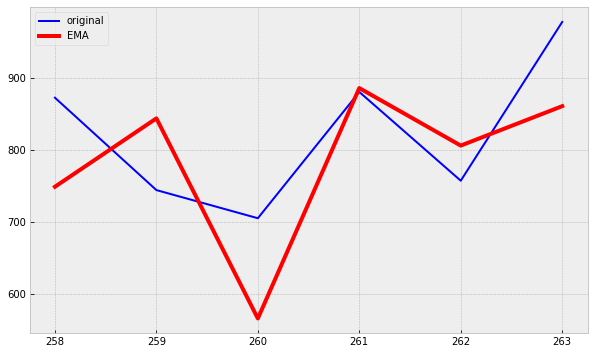

In [139]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(res_ema[-6:], color='red', linewidth='4', label='EMA')
    plt.legend()

In [140]:
print(f'MSE на валидационном ряде для модели EMA и стационарного ряда: {ema_errors:.2f}')

MSE на валидационном ряде для модели EMA и стационарного ряда: 13.01


In [141]:
ema_nst_errors = mean_squared_error(val_nst, res_ema[-6:])
print(f'MSE на валидационном ряде для модели EMA и нестационарного ряда: {ema_nst_errors:.2f}')

MSE на валидационном ряде для модели EMA и нестационарного ряда: 10069.77


Такой же результат как и раньше.

#### 1.4. Двойное экспоненциальное сглаживание

In [142]:
def predict_dema(series, alpha, beta, n_pred):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_pred):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return pd.Series(result)

In [143]:
def mse_dema(X, train, test):
    alpha, beta = X
    result = predict_dema(train, alpha, beta, len(test))
    predictions = result[-len(test_st):]
    error = mean_squared_error(predictions, test)
    return error

In [144]:
opt = minimize(mse_dema, x0=[0.1, 0.1], method="L-BFGS-B", 
               bounds = ((0.1, 0.9), (0.1, 0.9)), args= (train_st, test_st))

In [145]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 3.755740455458707
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([6.74134162e+00, 8.43769499e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 126
      nit: 23
   status: 0
  success: True
        x: array([0.1     , 0.576492])


In [225]:
predictions_dema = predict_dema(series_st[:-6], alpha_opt, beta_opt, len(val_st))
dema_errors = mse_dema((alpha_opt, beta_opt), series_st[:-6], val_st)

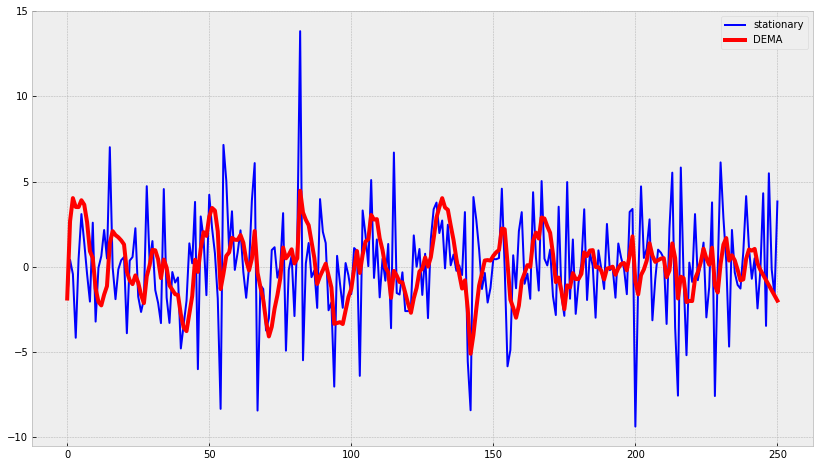

In [226]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='stationary')
    plt.plot(predictions_dema, color='red', linewidth='4', label='DEMA')
    plt.legend()

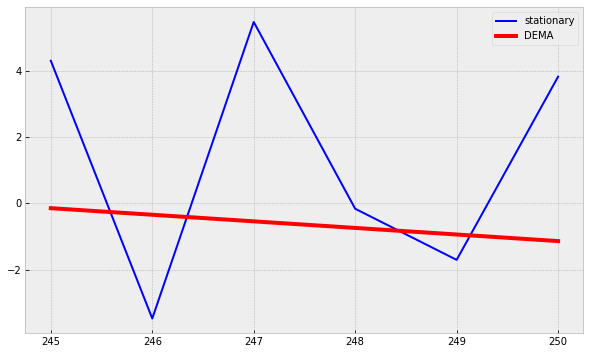

In [148]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_st[-6:], color='blue',label='stationary')
    plt.plot(predictions_dema[-6:], color='red', linewidth='4', label='DEMA')
    plt.legend()

In [149]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_dema = inverse_transform(predictions_dema, df_auto_reg)

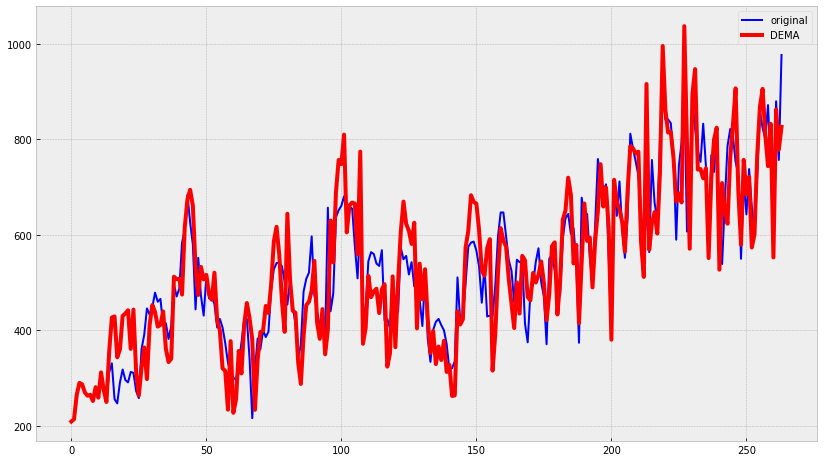

In [150]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_dema, color='red', linewidth='4', label='DEMA')
    plt.legend()

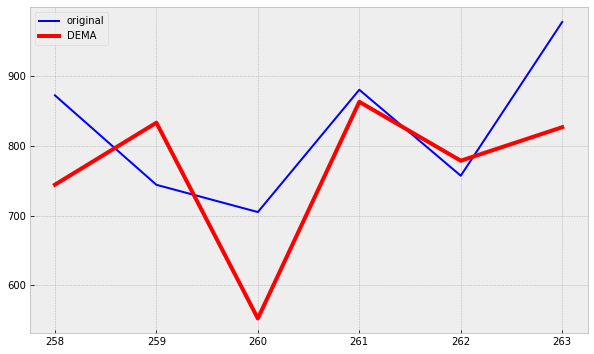

In [151]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(res_dema[-6:], color='red', linewidth='4', label='DEMA')
    plt.legend()

In [152]:
print(f'MSE на валидационном ряде для модели DEMA и стационарного ряда: {dema_errors:.2f}')

MSE на валидационном ряде для модели DEMA и стационарного ряда: 15.26


In [153]:
dema_nst_errors = mean_squared_error(val_nst, res_dema[-6:])
print(f'MSE на валидационном ряде для модели DEMA и нестационарного ряда: {dema_nst_errors:.2f}')

MSE на валидационном ряде для модели DEMA и нестационарного ряда: 11810.87


Модель DEMA выявила ложный тренд и получила самую большую ошибку.

#### 1.5. Хольт-Винтерс 

In [154]:
def initial_trend(series, season_len, i):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [155]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [156]:
def predict_tema(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen, i)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return pd.Series(result)

In [157]:
def mse_tema(X, train, test):
    alpha, beta, gamma = X
    result = predict_tema(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [158]:
opt = minimize(mse_tema, x0=[0.1,0.1,0.1], method="L-BFGS-B", 
               bounds = ((0.1, 0.9), (0.1, 0.9), (0.1, 0.9)), args= (train_st, test_st))

In [159]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 4.307571791314074
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([8.82906335e+00, 5.50670620e-06, 4.10030152e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 56
      nit: 9
   status: 0
  success: True
        x: array([0.1       , 0.58815847, 0.1       ])


In [207]:
predictions_tema = predict_tema(series_st[:-6], 12, alpha_opt, beta_opt, gamma_opt, len(val_st))
tema_errors = mse_tema((alpha_opt, beta_opt, gamma_opt), series_st[:-6], val_st)

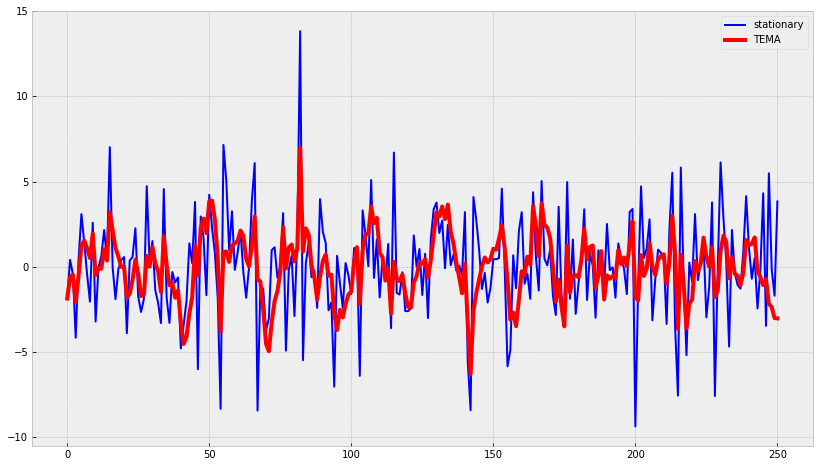

In [223]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='stationary')
    plt.plot(predictions_tema, color='red', linewidth='4', label='TEMA')
    plt.legend()

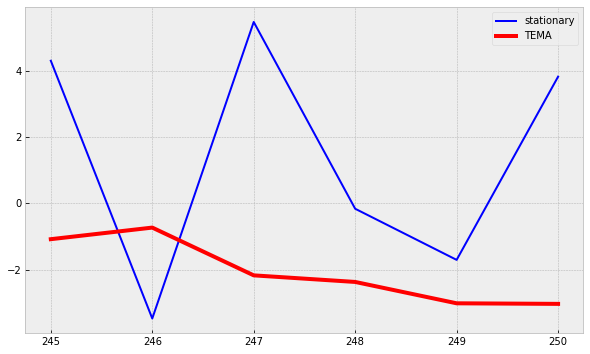

In [209]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_st[-6:], color='blue',label='stationary')
    plt.plot(predictions_tema[-6:], color='red', linewidth='4', label='TEMA')
    plt.legend()

In [210]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_tema = inverse_transform(predictions_tema, df_auto_reg)

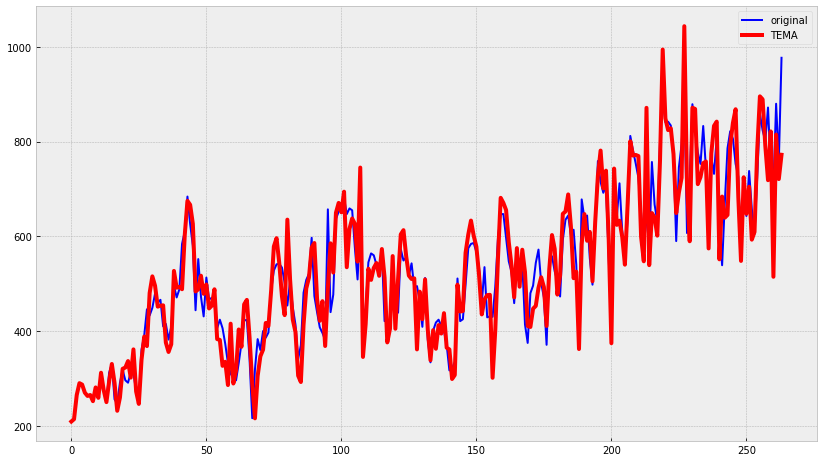

In [211]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_tema, color='red', linewidth='4', label='TEMA')
    plt.legend()

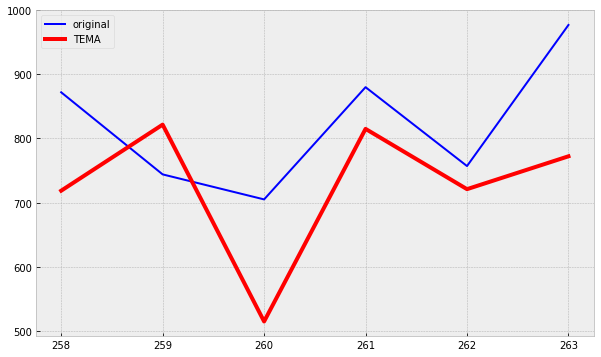

In [212]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(res_tema[-6:], color='red', linewidth='4', label='TEMA')
    plt.legend()

In [213]:
print(f'MSE на валидационном ряде для модели TEMA и стационарного ряда: {tema_errors:.2f}')

MSE на валидационном ряде для модели TEMA и стационарного ряда: 24.83


In [214]:
tema_nst_errors = mean_squared_error(val_nst, res_tema[-6:])
print(f'MSE на валидационном ряде для модели TEMA и нестационарного ряда: {tema_nst_errors:.2f}')

MSE на валидационном ряде для модели TEMA и нестационарного ряда: 18876.03


#### 1.6.  Модель предсказывающая нули на всем диапазоне.

In [215]:
predictions_zero = pd.Series(np.zeros_like(predictions_tema))

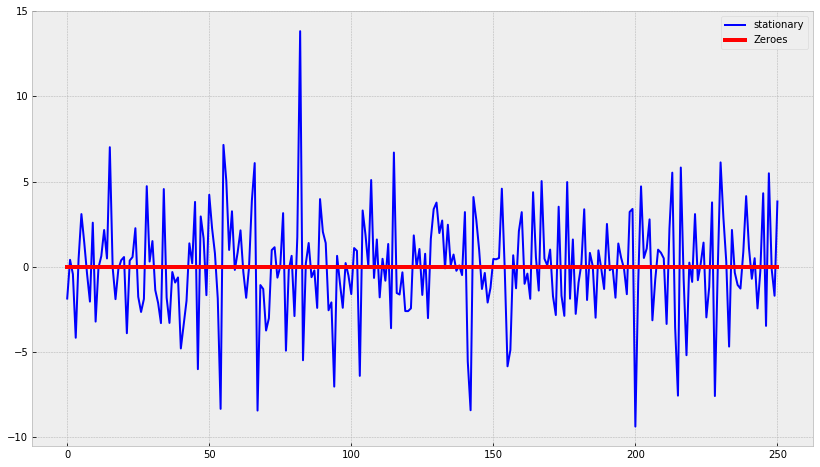

In [216]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_st, color='blue',label='stationary')
    plt.plot(predictions_zero, color='red', linewidth='4', label='Zeroes')
    plt.legend()

In [217]:
# посмотрим на график предсказаний в сравнении с исходным временным рядом
res_zero = inverse_transform(predictions_zero, df_auto_reg)

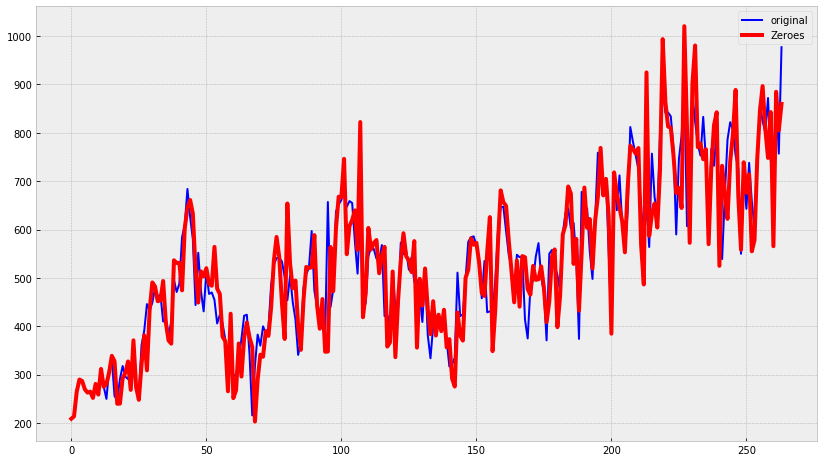

In [219]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(res_zero, color='red', linewidth='4', label='Zeroes')
    plt.legend()

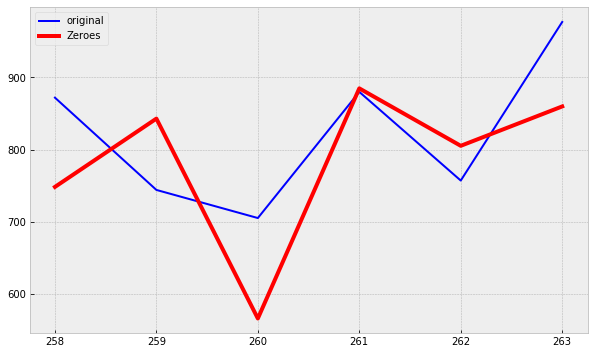

In [227]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(res_zero[-6:], color='red', linewidth='4', label='Zeroes')
    plt.legend()

In [222]:
zero_nst_errors = mean_squared_error(val_nst, res_zero[-6:])
print(f'MSE на валидационном ряде для модели предсказывающей нули и нестационарного ряда: {zero_nst_errors:.2f}')

MSE на валидационном ряде для модели предсказывающей нули и нестационарного ряда: 10101.24


Модель предсказывающая нули дает такие же результаты.

Модели класса MA получили похожие результаты. При этом модели DEMA и TEMA получили менее точные предсказания, чем MA, WMA и EMA. Т.к. пытались найти тренд и сезонность в стационарном ряде (из которого тренд и сезонность уже убрали). Оптимальные параметры (минимум MSE) достигаются при усреднении за большой период, в результате чего получаются предсказания вблизи нуля (среднее значение стационарного ряда). Получается, что стационарный ряд можно просто приблизить нулевыми значениями на всем интервале без использования каких-либо моделей.

# II. Нестационарный ряд

#### 2.1 Скользящая средняя

In [168]:
errors = []
for N in range(1, 24):
    errors.append(mse_ma(N, train_nst, test_nst))

In [169]:
N_opt = np.array(errors).argmin() + 1
N_opt

13

In [170]:
predictions_ma = predict_ma(series_nst[:-6], N_opt, len(val_nst))
ma_errors = mse_ma(N_opt, series_nst[:-6], val_nst)

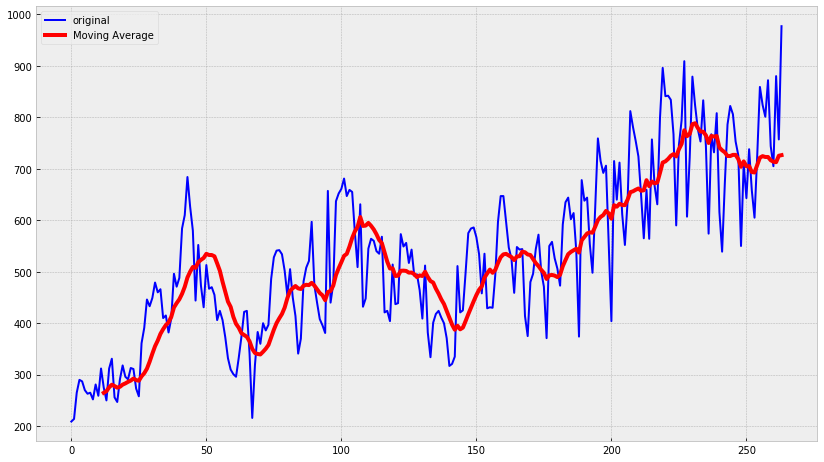

In [171]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(predictions_ma, color='red', linewidth='4', label='Moving Average')
    plt.legend()

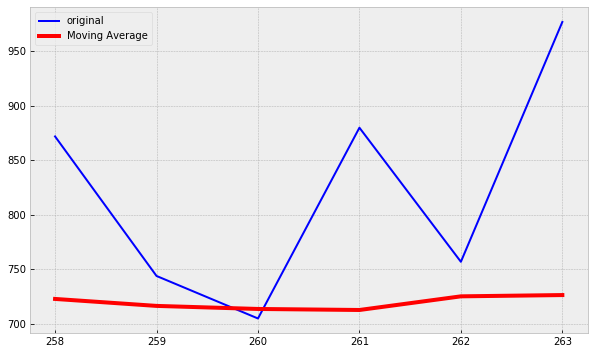

In [172]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(predictions_ma[-6:], color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [173]:
print(f'MSE на валидационном ряде для модели MA: {ma_errors:.2f}')

MSE на валидационном ряде для модели MA: 19129.93


На нестационарном ряде модель MA предсказывает хуже, чем на стационарном.

#### 2.2.  Взвешенная скользящая средняя (последовательные числа)

In [228]:
errors = []
for N in range(4, 24):
    errors.append(mse_wma(N, train_nst, test_nst))

In [229]:
N_opt = np.array(errors).argmin() + 4
N_opt

23

In [230]:
predictions_wma = predict_wma(series_nst[:-6], N_opt, len(val_nst))
wma_errors = mse_wma(N_opt, series_nst[:-6], val_nst)

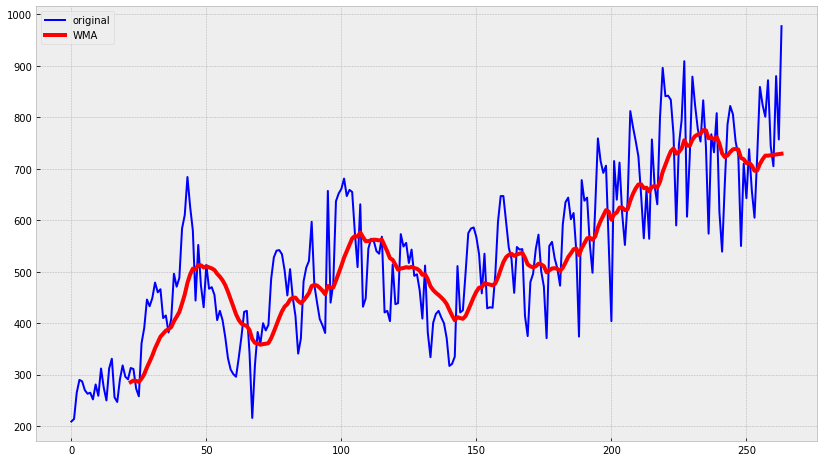

In [231]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(predictions_wma, color='red', linewidth='4', label='WMA')
    plt.legend()

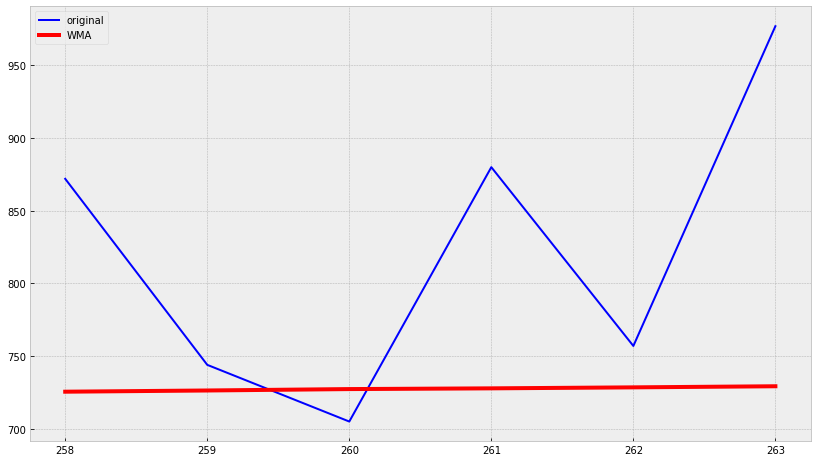

In [178]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(predictions_wma[-6:], color='red', linewidth='4', label='WMA')
    plt.legend()

In [179]:
print(f'MSE на валидационном ряде для модели WMA: {wma_errors:.2f}')

MSE на валидационном ряде для модели WMA: 17933.92


#### 2.3. Экспоненциальное сглаживание

In [232]:
opt = minimize(mse_ema, x0=[0.15], method="L-BFGS-B", 
               bounds = ((0.15, 0.9),), args= (train_nst, test_nst))

In [233]:
alpha_opt = opt.x[0]
print(opt)

      fun: 10217.897909772199
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([14922.03118687])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
   status: 0
  success: True
        x: array([0.15])


In [234]:
alpha_opt

0.15

In [235]:
predictions_ema = predict_ema(series_nst[:-6], alpha_opt, len(val_nst))
ema_errors = mse_ema(alpha_opt, series_nst[:-6], val_nst)

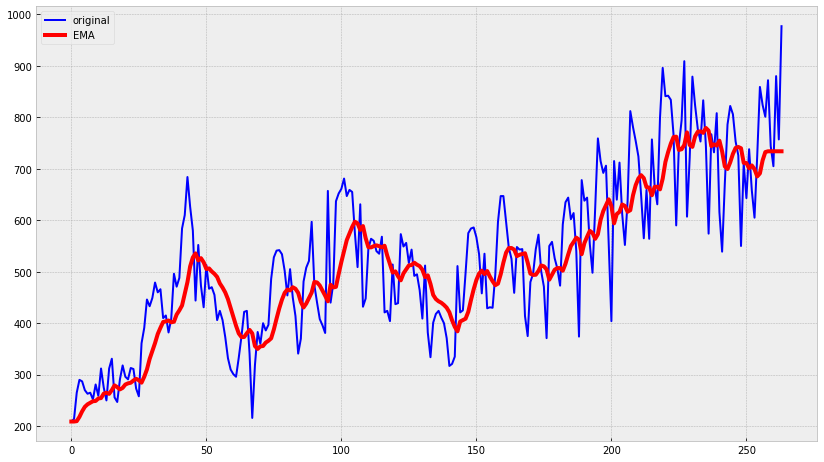

In [236]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(predictions_ema, color='red', linewidth='4', label='EMA')
    plt.legend()

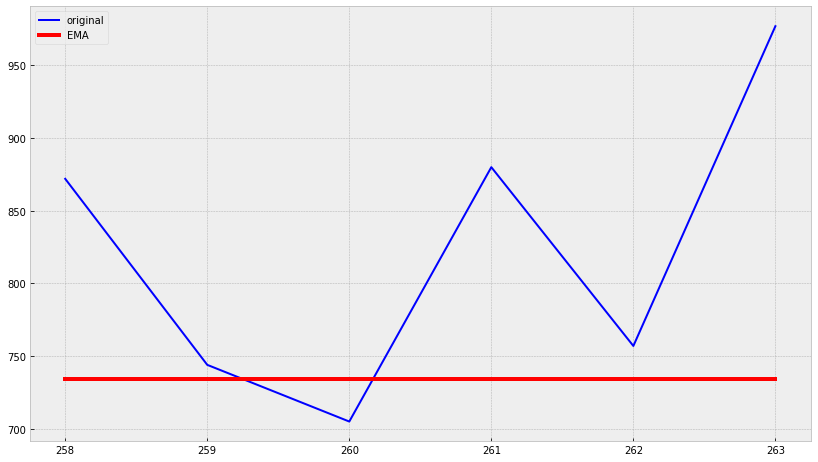

In [237]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(predictions_ema[-6:], color='red', linewidth='4', label='EMA')
    plt.legend()

In [238]:
print(f'MSE на валидационном ряде для модели EMA: {ema_errors:.2f}')

MSE на валидационном ряде для модели EMA: 16816.37


#### 2.4. Двойное экспоненциальное сглаживание

In [239]:
opt = minimize(mse_dema, x0=[0.15, 0.15], method="L-BFGS-B", 
               bounds = ((0.15, 0.9), (0.15, 0.9)), args= (train_nst, test_nst))

In [240]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 3789.6104150889223
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -374.35534068, -2754.13462987])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 75
      nit: 15
   status: 0
  success: True
        x: array([0.40411441, 0.88469345])


In [241]:
predictions_dema = predict_dema(series_nst[:-6], alpha_opt, beta_opt, len(val_nst))
dema_errors = mse_dema((alpha_opt, beta_opt), series_nst[:-6], val_nst)

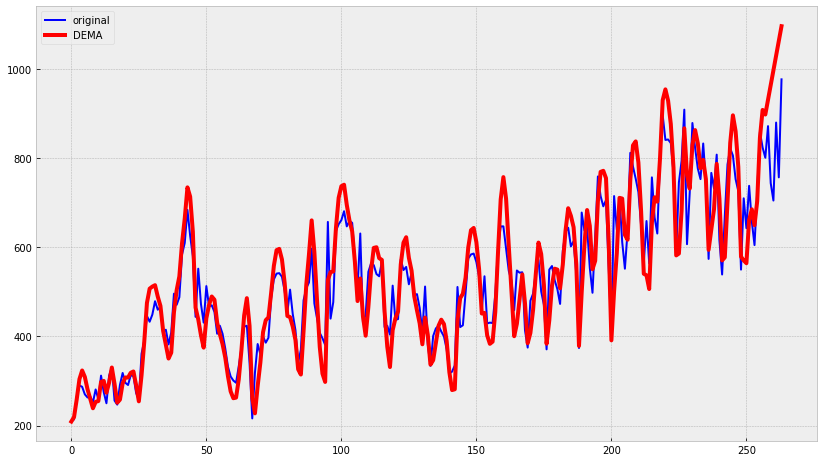

In [242]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(predictions_dema, color='red', linewidth='4', label='DEMA')
    plt.legend()

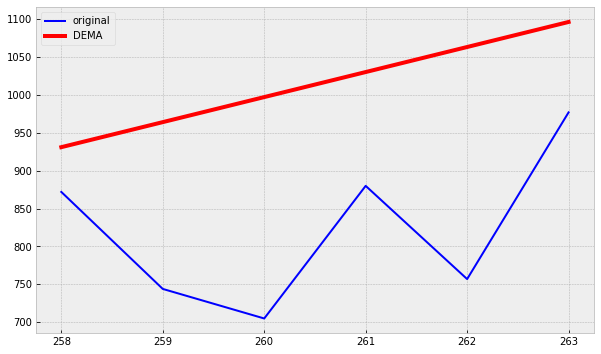

In [243]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(predictions_dema[-6:], color='red', linewidth='4', label='DEMA')
    plt.legend()

In [192]:
print(f'MSE на валидационном ряде для модели DEMA: {dema_errors:.2f}')

MSE на валидационном ряде для модели DEMA: 44646.34


DEMA угадала тренд, но в целом прогноз сильно смещен.

#### 2.5. Хольт-Винтерс 

In [244]:
opt = minimize(mse_tema, x0=[0.15,0.15,0.15], method="L-BFGS-B", 
               bounds = ((0.15, 0.9), (0.15, 0.9), (0.15, 0.9)), args= (train_nst, test_nst))

In [245]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 525.5245226755957
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00087539, -0.00043201, -0.00029559])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 212
      nit: 31
   status: 0
  success: True
        x: array([0.17281468, 0.70449174, 0.25737098])


In [246]:
predictions_tema = predict_tema(series_nst[:-6], 12, alpha_opt, beta_opt, gamma_opt, len(val_nst))
tema_errors = mse_tema((alpha_opt, beta_opt, gamma_opt), series_nst[:-6], val_nst)

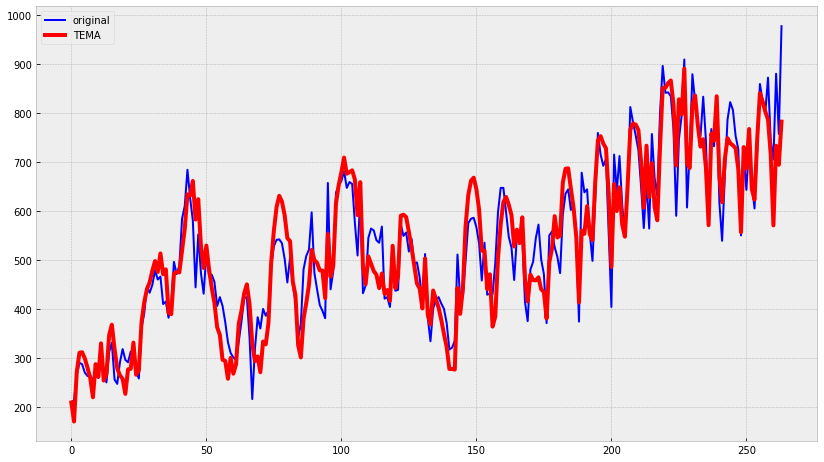

In [247]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(series_nst, color='blue',label='original')
    plt.plot(predictions_tema, color='red', linewidth='4', label='TEMA')
    plt.legend()

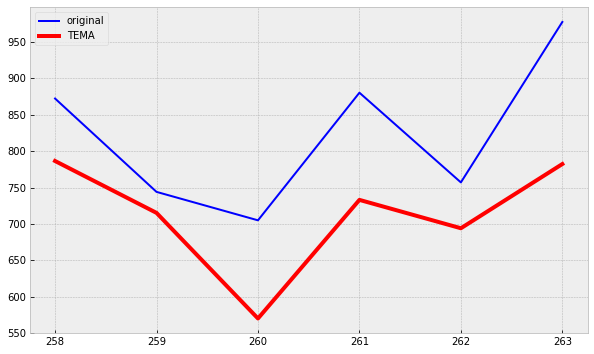

In [248]:
# график с предсказаниями
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 6))
    plt.plot(series_nst[-6:], color='blue',label='original')
    plt.plot(predictions_tema[-6:], color='red', linewidth='4', label='TEMA')
    plt.legend()

In [198]:
print(f'MSE на валидационном ряде для модели TEMA: {tema_errors:.2f}')

MSE на валидационном ряде для модели TEMA: 14964.18


Модель Хольта-Винтерса лучше всего справилась прогнозированием, уловив и сезонность и тренд, но в целом прогноз смещен вниз.

В целом на стационарном ряде получились более точные предсказания, чем на нестационарном. С нестационарным рядом лучше всего справилась модель Хольта-Винтерса. Со стационарным - MA, WMA и EMA.